In [1]:
"""
Created on Sun Feb 12 15:48:12 2017
@author: toniwz 
GitHub: https://github.com/toniwz
"""

from scipy.stats import norm
import numpy as np
import pandas as pd
import math

def VaR(Returns, Formula = 'Parametric Normal', Confidence_Interval = 0.95 , Period_Interval = None ,
        EWMA_Discount_Factor = 0.94, Series = False ,removeNa = True):
    
    '''
    This function can caluclate both single value VaR and series of VaR values through time.
    Supported formulas as Parametric Normal, Parametric EWMA, Historical Simulation and Filtered Historical Simulation
    
    '''
    
    
    # Removes the NAs from the series
    if removeNa: Returns = Returns[pd.notnull(Returns)]
    
    # Data need to be returns already, then here the interval for the sampling is set for No input
    if (Series == True and Period_Interval == None):
        Period_Interval = 100
    elif Period_Interval == None: 
        Period_Interval = len(Returns)
    
    #==========================================================================
    #==========================================================================
    #==========================================================================
    
    #===============================
    #     Parametric Normal VaR 
    #===============================
    if Formula == 'Parametric Normal':
        
        if Series == False: 
            Data = Returns[-Period_Interval:]
            stdev = np.std(Data)
            Value_at_Risk = stdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'ParVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                stdev = np.std(Data)
                Value_at_Risk[-i-1] = stdev*norm.ppf(Confidence_Interval)
    
    #============================
    # EWMA Parametric VaR 
    #============================
    if Formula == 'Parametric EWMA':
    
        ## Defining exponentially smoothed weights components ##
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)
        
        if Series == False:
            sqrdData = (Returns[-Period_Interval:])**2 ## Squaring returns for the formula
            EWMAstdev=math.sqrt(sum(Weights*sqrdData))
            Value_at_Risk = EWMAstdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'EWMAVaR')
            sqrdReturns = Returns**2 ## For efficiency here we square returns first so the loop does not do it repeadetly
            ## This loop repeats the VaR calculation iterated for every xxx period interval
            for i in range(0,len(Returns)-Period_Interval):
                ## this is needed as, supposing x is a number, referencing a pd series as a[x,0] is a mistake. correct is a[x:]
                if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
                else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]
        
                EWMAstdev=math.sqrt(sum(Weights*sqrdData))
                ## unfortunately pd series work differently for singular entries. So if a[x:] gets up to the last number
                ## a[] does not work. So a[-1] will get the equivalent to the last of a[x:-1] 
                Value_at_Risk[-i-1] = EWMAstdev*norm.ppf(Confidence_Interval)
    
    
    #============================
    #    Historical Simulation 
    #============================
    if Formula == 'Historical Simulation':
        
        if Series == False:
            Data = Returns[-Period_Interval:]
            Value_at_Risk = -np.percentile(Data,1-Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'HSVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                Value_at_Risk[-i-1] = -np.percentile(Data,1-Confidence_Interval)
        
    #==================================== 
    #   Filtered Historical Simulation 
    #====================================
    if Formula == 'Filtered Historical Simulation': 
        
        # Defining exponentially smoothed weights components 
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)
    
        
        Value_at_Risk = pd.Series(index=Returns.index, name = 'FHSVaR')
        EWMAstdev = np.empty([len(Returns)-Period_Interval,])
        stndrData = pd.Series(index=Returns.index)
        
        # For efficiency here we square returns first so the loop does not do it repeadetly 
        sqrdReturns = Returns**2
        
        # Computations here happen in different times, because we first need all the EWMAstdev
        # First get the stdev according to the EWMA
        for i in range(0,len(Returns)-Period_Interval):
            if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
            else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]
                
            EWMAstdev[-i-1]=math.sqrt(sum(Weights*sqrdData))
        
        # Now get the Standardized data by dividing for the EWMAstdev.
        # Length is here -1 because we standardize by the EWMAstdev of the PREVIOUS period.
        # Hence also EWMAstdev is [-i-2] instead of [-i-1].
        for i in range(0,len(Returns)-Period_Interval-1):
            stndrData[-i-1]=Returns[-i-1]/EWMAstdev[-i-2]
        stndrData = stndrData[pd.notnull(stndrData)]
        #Finally get the percentile and unfilter back the data
        for i in range(0,len(stndrData)-Period_Interval):
            if i == 0: stndrData2 = stndrData[-(Period_Interval):]
            else: stndrData2 = stndrData[-(Period_Interval+i):-i]   
            
            stndrData_pct=np.percentile(stndrData2,1-Confidence_Interval)
        # Unfilter back with the CURRENT stdev
            Value_at_Risk[-i-1]=-(stndrData_pct*EWMAstdev[-i-1])
        
        
        # For FHS the single take of VaR does not work because we need to standardize for the preceeding stdev
        # hence it is always necessary to calculate the whole series and take the last value
        if Series == True:
            Value_at_Risk = Value_at_Risk
        if Series == False:
            Value_at_Risk = Value_at_Risk[-1]
        
             

    return(Value_at_Risk)

def VaR_Compare(Returns, Confidence_Interval = 0.95 , Period_Interval = 100 ,EWMA_Discount_Factor = 0.94):
    
    'This function calculates different VaR series and plots it in the same graph'
    
    # Use for each VaR call the same values, here they are set
    Ret=Returns
    CI = Confidence_Interval
    PI = Period_Interval
    EWMAdf = EWMA_Discount_Factor

    # Call the single VaR series
    VaRPN=VaR(Ret, Formula = 'Parametric Normal', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaREWMA=VaR(Ret, Formula = 'Parametric EWMA', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRHS=VaR(Ret, Formula = 'Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRFHS=VaR(Ret, Formula = 'Filtered Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)

    # Concat the different VaR series in the same dataframe and plot it
    AllVaR = pd.concat([VaRPN,VaREWMA,VaRHS,VaRFHS], axis = 1) 
    AllVaR.plot(lw=1)
    
    return(AllVaR)

In [7]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import math
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

start = datetime.datetime(2017, 1, 3)
end = datetime.datetime(2019, 10, 4)

from quandl_config import QUANDL_API_KEY # file with my personal Quandl Key
symbol = 'WIKI/GOOG'
df = web.DataReader(symbol, 'quandl', start, end, api_key = QUANDL_API_KEY)['Close']

In [8]:
ret = df.pct_change()

,ParVaR,EWMAVaR,HSVaR,FHSVaR
Date,,,,
2018-03-26,NaN,NaN,NaN,NaN
2018-03-23,NaN,NaN,NaN,NaN
2018-03-22,NaN,NaN,NaN,NaN
2018-03-21,NaN,NaN,NaN,NaN
2018-03-20,NaN,NaN,NaN,NaN
...,...,...,...,...
2017-01-09,0.013658,0.015785,0.034392,0.039129
2017-01-06,0.013611,0.015858,0.034392,0.039309
2017-01-05,0.013783,0.016334,0.034392,0.040489


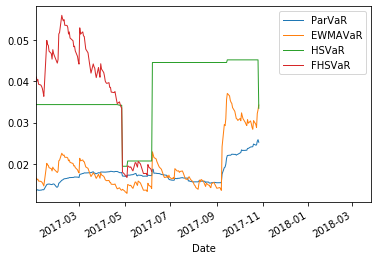

In [9]:
VaR_Compare(ret)

In [12]:
VaR(ret)

0.02018290041354218